# Introduction

This notebook will take a data-driven approach to generating word lists for mental functions that are related to brain circuitry. The overall process is as follows:

1. Cluster brain structures into circuits by PMI-weighted co-occurrences with mental function terms.
2. Identify the mental function terms most highly associated to each circuit over a range of list lengths.
3. Select the list length for each circuit that maximizes word-structure classification performance. 
4. Select the number of circuits that maximizes circuit-function classification performance.

# Load the data

In [1]:
import pandas as pd
from utilities import *

## Brain activation coordinates

In [2]:
act_bin = load_coordinates()
print("Document N={}, Structure N={}".format(act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=114


## Terms for mental functions

In [3]:
version = 190124
dtm_bin = load_doc_term_matrix(version=version, binarize=True)

In [4]:
lexicon = load_lexicon(["cogneuro"])
lexicon = sorted(list(set(lexicon).intersection(dtm_bin.columns)))
len(lexicon)

2208

In [5]:
dtm_bin = dtm_bin[lexicon]
print("Document N={}, Term N={}".format(dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=2208


## Document splits

In [6]:
train, val = [[int(pmid.strip()) for pmid in open("../data/splits/{}.txt".format(split))] for split in ["train", "validation"]]
print("Training N={}, Validation N={}".format(len(train), len(val)))

Training N=12708, Validation N=3631


# Link structures to functions

Links are computed as PMI-weighted co-occurrences across the training set

In [7]:
import numpy as np

In [8]:
stm = np.dot(act_bin.loc[train].transpose(), dtm_bin.loc[train])
stm = pd.DataFrame(stm, columns=dtm_bin.columns, index=act_bin.columns)
stm = pmi(stm, positive=False)
stm = stm.dropna(axis=1, how="all") # Drop terms with no co-occurrences
print("Structure N={}, Term N={}".format(stm.shape[0], stm.shape[1]))

Structure N=114, Term N=1637


### Terms most strongly linked to the left amygdala

In [9]:
stm.loc["left_amygdala"].sort_values(ascending=False)[:10]

olfactory_stimulus_transduction      4.273268
auditory_system_function             3.174656
letter_naming_task                   2.886974
eye_puff                             2.481509
face_identification_task             2.427441
waisinformation                      2.039676
emotion_expression_identification    2.039676
pavlovian_conditioning_task          2.021976
social_norm_processing_task          1.970683
offensive_aggression                 1.937893
Name: left_amygdala, dtype: float64

### Structures most strongly linked to *face_identification_task*

In [10]:
stm["face_identification_task"].sort_values(ascending=False)[:10]

right_parahippocampal_gyrus_anterior_division    2.526130
left_frontal_medial_cortex                       2.453793
right_amygdala                                   2.450999
left_parahippocampal_gyrus_anterior_division     2.435121
right_frontal_medial_cortex                      2.429052
left_amygdala                                    2.427441
right_hippocampus                                2.116207
left_temporal_pole                               2.013696
right_temporal_pole                              1.987670
left_cingulate_gyrus_anterior_division           1.569111
Name: face_identification_task, dtype: float64

# Generate the ontology

## 1. Cluster brain structures by functions

In [11]:
import os
from sklearn.cluster import KMeans
from scipy.stats import pointbiserialr

In [12]:
circuit_counts = range(2, 41) # Range over which ROC-AUC becomes asymptotic
list_lens = range(5, 26) # Same range as RDoC and the DSM

In [13]:
for k in circuit_counts:
    circuit_file = "circuits/circuits_k{:02d}.csv".format(k)
    if not os.path.isfile(circuit_file):
        kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=42)
        kmeans.fit(stm)
        clust = pd.DataFrame({"STRUCTURE": act_bin.columns, 
                              "CLUSTER": [l+1 for l in list(kmeans.labels_)]})
        clust = clust.sort_values(["CLUSTER", "STRUCTURE"])
        clust.to_csv(circuit_file, index=None)

## 2. Identify associated terms for mental functions

In [14]:
for k in circuit_counts:
    circuit_file = "circuits/circuits_k{:02d}.csv".format(k)
    clust = pd.read_csv(circuit_file, index_col=None)
    outfile = "lists/lists_k{:02d}.csv".format(k)
    if not os.path.isfile(outfile):
        lists = pd.DataFrame()
        for i in range(k):
            structures = list(clust.loc[clust["CLUSTER"] == i+1, "STRUCTURE"])
            centroid = np.mean(act_bin.loc[train, structures], axis=1)
            R = pd.Series([pointbiserialr(dtm_bin.loc[train, word], centroid)[0] 
                           for word in dtm_bin.columns], index=dtm_bin.columns)
            R = R[R > 0].sort_values(ascending=False)[:max(list_lens)]
            R = pd.DataFrame({"CLUSTER": [i+1 for l in range(max(list_lens))], 
                              "TOKEN": R.index, "R": R.values})
            lists = lists.append(R)
        lists.to_csv(outfile, index=None)

## 3. Select number of words per domain

Word list lengths were selected by mean ROC-AUC of forward and reverse classifiers for each circuit. The number of circuits will be selected across values of k using the lists of optimized length, this time training classifiers that use all the circuits at that k. All classifiers were optimized over a grid search for regularization strength, penalty, and intercept.

In [15]:
import pickle

In [16]:
directions = ["forward", "reverse"]

In [17]:
fits = {}
for d in directions:
    fits[d] = {}
    for k in circuit_counts:
        fits[d][k] = pickle.load(open("sherlock/fits/{}_k{:02d}_oplen.p".format(d, k), "rb"), encoding="latin1")

## 4. Select optimal number of domains

### Circuit-level features

In [18]:
from sklearn.preprocessing import binarize

In [19]:
features = {k: {} for k in circuit_counts}
for k in circuit_counts:
    domains = range(1, k+1)
    lists, circuits = load_ontology(k)
    function_features = pd.DataFrame(index=dtm_bin.index, columns=domains)
    structure_features = pd.DataFrame(index=act_bin.index, columns=domains)
    for i in domains:
        functions = lists.loc[lists["CLUSTER"] == i, "TOKEN"]
        function_features[i] = dtm_bin[functions].sum(axis=1)
        structures = circuits.loc[circuits["CLUSTER"] == i, "STRUCTURE"]
        structure_features[i] = act_bin[structures].sum(axis=1)
    function_features = pd.DataFrame(doc_mean_thres(function_features), 
                                     index=dtm_bin.index, columns=domains)
    structure_features = pd.DataFrame(binarize(structure_features), 
                                     index=act_bin.index, columns=domains)
    features[k]["function"] = function_features
    features[k]["structure"] = structure_features

### Area under the receiver operating characteristic curve (ROC-AUC)

In [20]:
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [21]:
rocauc_scores = compute_eval_scores(roc_auc_score, directions, features, fits, val)

In [22]:
rocauc_boot = compute_eval_boot(roc_auc_score, directions, features, fits, val, n_iter=10000)

Processing 0th k
Processing 10th k
Processing 20th k
Processing 30th k


In [23]:
rocauc_null = compute_eval_null(roc_auc_score, directions, features, fits, val, n_iter=10000)

Processing 0th k
Processing 10th k
Processing 20th k
Processing 30th k


In [24]:
directions += ["mean"]
shapes = [">", "<", "D"]

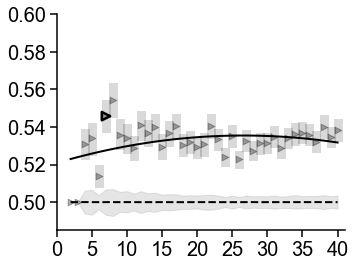

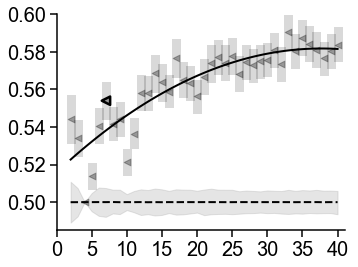

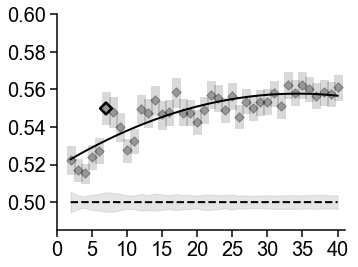

In [25]:
for direction, shape in zip(directions, shapes):
    plot_scores(rocauc_scores, direction, rocauc_boot, rocauc_null, 
                "rocauc", shape=shape, ylim=[0.485,0.6])

# Name the domains

In [26]:
op_k = 7
lists, circuits = load_ontology(op_k)

In [27]:
k2name = {}
for k in range(op_k):
    degrees = term_degree_centrality(k+1, lists, circuits, dtm_bin, train)
    name = nounify(degrees.index[0], dtm_bin).upper()
    k2name[k+1] = name
    print("{}: {}".format(k+1, name))

1: MEANING
2: MANIPULATION
3: ANTICIPATION
4: LANGUAGE
5: VISION
6: EMOTION
7: COGNITION


## Export ontology with domain names

In [28]:
order = [6, 3, 7, 5, 2, 1, 4]
names = [k2name[k] for k in order]
k2order = {k: order.index(k)+1 for k in range(1,op_k+1)}

### Function term lists

In [29]:
columns = ["ORDER", "CLUSTER", "DOMAIN", "TOKEN", "R", "ROC_AUC"]
lists["ORDER"] = [k2order[k] for k in lists["CLUSTER"]]
lists["DOMAIN"] = [k2name[k] for k in lists["CLUSTER"]]
lists = lists.sort_values(["ORDER", "R"], ascending=[True, False])
lists = lists[columns]
lists.to_csv("lists/lists_data-driven.csv", index=None)
lists.head()

,ORDER,CLUSTER,DOMAIN,TOKEN,R,ROC_AUC
103,1,6,EMOTION,emotion,0.204320,0.510077
104,1,6,EMOTION,fear,0.202945,0.510077
105,1,6,EMOTION,memory,0.181393,0.510077
106,1,6,EMOTION,valence,0.173991,0.510077
107,1,6,EMOTION,facial_expression,0.171110,0.510077


### Brain circuits

In [30]:
columns = ["ORDER", "CLUSTER", "DOMAIN", "STRUCTURE"]
circuits["ORDER"] = [k2order[k] for k in circuits["CLUSTER"]]
circuits["DOMAIN"] = [k2name[k] for k in circuits["CLUSTER"]]
circuits = circuits.sort_values(["ORDER", "STRUCTURE"])
circuits = circuits[columns]
circuits.to_csv("circuits/clusters_data-driven.csv", index=None)
circuits.head()

,ORDER,CLUSTER,DOMAIN,STRUCTURE
84,1,6,EMOTION,left_amygdala
85,1,6,EMOTION,left_hippocampus
86,1,6,EMOTION,left_parahippocampal_gyrus_anterior_division
87,1,6,EMOTION,right_amygdala
88,1,6,EMOTION,right_hippocampus


In [31]:
circuit_mat = pd.DataFrame(0.0, index=act_bin.columns, columns=names)
for name in names:
    structures = circuits.loc[circuits["DOMAIN"] == name, "STRUCTURE"]
    for structure in structures:
        circuit_mat.loc[structure, name] = 1.0
circuit_mat.to_csv("circuits/circuits_data-driven.csv")
circuit_mat.head()

,EMOTION,ANTICIPATION,COGNITION,VISION,MANIPULATION,MEANING,LANGUAGE
left_frontal_pole,0.0,0.0,1.0,0.0,0.0,0.0,0.0
left_insular_cortex,0.0,0.0,1.0,0.0,0.0,0.0,0.0
left_superior_frontal_gyrus,0.0,0.0,0.0,0.0,1.0,0.0,0.0
left_middle_frontal_gyrus,0.0,0.0,0.0,0.0,1.0,0.0,0.0
left_inferior_frontal_gyrus_pars_triangularis,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Visualize the circuits

In [32]:
atlas = load_atlas()

In [33]:
purples = make_cmap([(1,1,1), (0.365,0,0.878)])
magentas = make_cmap([(1,1,1), (0.620,0,0.686)])
yellows = make_cmap([(1,1,1), (0.937,0.749,0)])
cmaps = ["Blues", magentas, yellows, "Greens", "Reds", purples, "Oranges"]


EMOTION


/Users/ehbeam/.local/lib/python3.6/site-packages/nilearn/plotting/find_cuts.py:285: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data[slices] *= 1.e-3


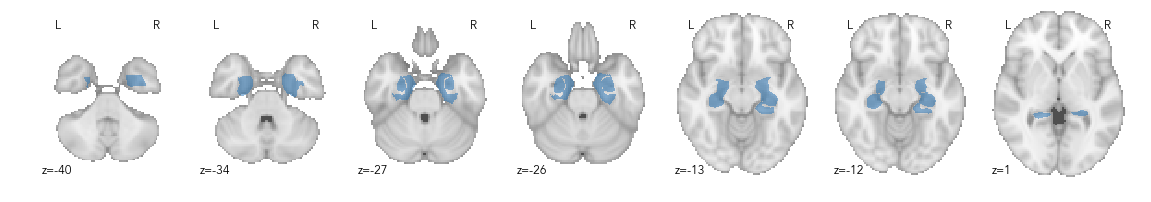


ANTICIPATION


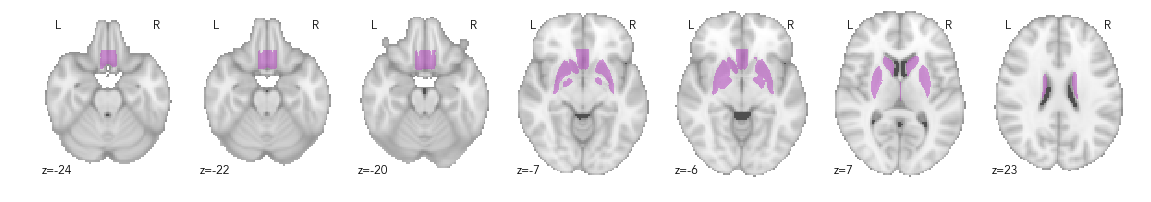


COGNITION


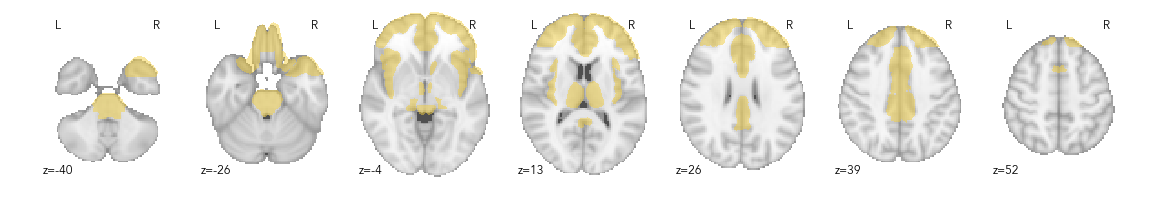


VISION


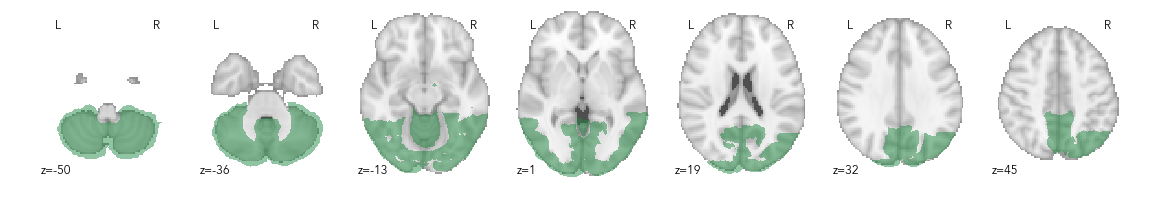


MANIPULATION


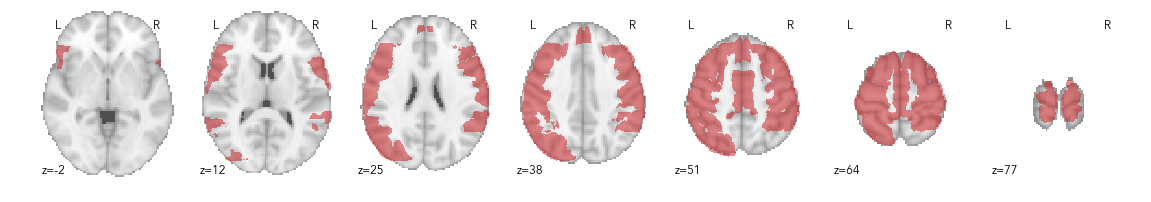


MEANING


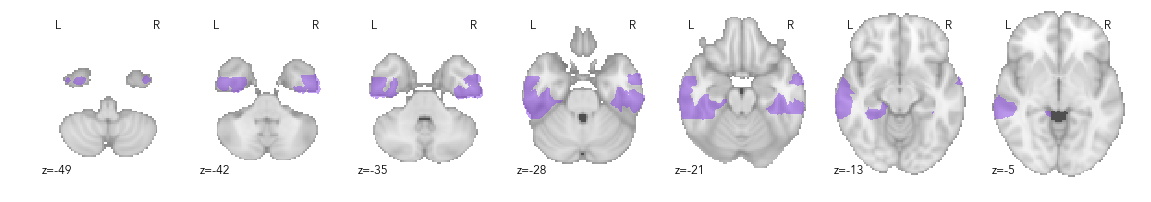


LANGUAGE


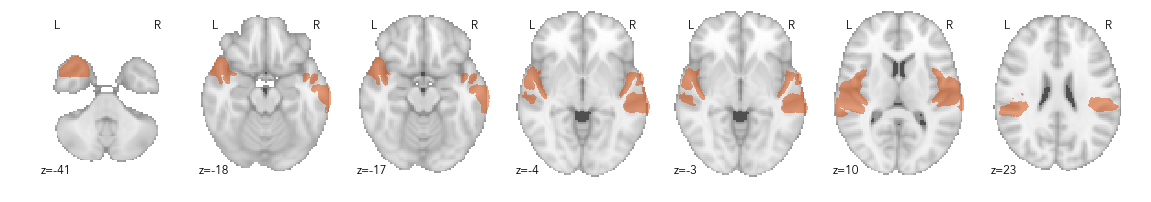

In [34]:
map_plane(circuit_mat, atlas, "figures/circuits/data-driven", 
          suffix="_z", cmaps=cmaps, plane="z", cbar=False, vmin=0.0, vmax=2.0,
          verbose=False, print_fig=True, annotate=True)

In [35]:
for plane in ["x", "y"]:
    map_plane(circuit_mat, atlas, "figures/circuits/data-driven", 
          suffix="_"+plane, cmaps=cmaps, plane=plane, cbar=False, vmin=0.0, vmax=2.0,
          verbose=False, print_fig=False, annotate=True)